In [15]:
# set up path to import my python scripts
import sys
import os
src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path+"/src")

In [16]:
# import my functions
from prep_data import get_csv_file_links, get_specific_year, count_NaNs, remove_unreasonable_measurements

ImportError: cannot import name 'remove_unreasonable_measurements' from 'prep_data' (/home/richy/Documents/dai/repos/haleakala-viewing-conditions/src/prep_data.py)

In [18]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')

In [10]:
# df = pd.read_csv('../data/2020.csv')

## Data Cleaning Notes
The 2020.csv data failed to load because some rows had more than 13 columns.   
Looking at the data I noticed several things.  
- The extra columns were generally '\N' values   
- I did notice one case were a datetime and subsequent rows were in the middle of a previous time and that same datetime was the subsequent row.   
- There was also another issue where it looked like two columns were swapped back and forth. The one was typically 50000 and the other less than 1 so it was easy to see.  

I am going to try and load another year to see if these problem keeps poping up in order to determine how to deal with it.

## IFA readme.txt
```
These are comma seperated files that can easily be imported into statistical software.
Data starts in 1994, recorded as 10 minute averages.
November 2006, switched to 10 second raw numbers.
All data is filtered, out of range and extraneous points have been replaced with "\N".
Fields are:
NAME		UNITS
___________________________________
date		MONTH/DAY/YEAR HH:MM:SS
temperature 	DEGREES CELSIUS
pressure 	MILLIBARS	
humidity 	PERCENT
wind_speed 	METERS/SECOND
wind_direction	DEGREES (CW FROM NORTH)
visibility	METERS
co2		PPM
insolation	LANGLEYS/HOUR
vertical_wind_speed METERS/SECOND
precipitation	INCHES
10min,
dewpoint	DEGREES CELSIUS
```

### Columns of Interest in determining Green/Yellow/Red Weather

**Temperature** and **Dew Point**  
Dew Point Delta = Temperature - Dew Point  
Green - > 10 def F  
Red - < 5 deg F  

**Humidity**  
Green < 75  
red > 85  

**Wind**  
Green - < 20 knots, gusts < 30knots  
red > 25 knots gusts > 30  

**visibility**
Cloud Cover  
yellow - anything other than clear down do low elevation ~15deg  

**precipitation**  
red for any


In [19]:
column_names = ['date_time','temperature','pressure','humidity','wind_speed','wind_direction','visibility','co2','insolation','vertical_wind_speed','precipitation','10min','dewpoint']
columns_of_interest = ['date_time','temperature','humidity','wind_speed','visibility','precipitation','dewpoint']

In [20]:

base_url = "http://kopiko.ifa.hawaii.edu/weather/archivedata/"
csv_urls = get_csv_file_links(base_url)
print(csv_urls)

['http://kopiko.ifa.hawaii.edu/weather/archivedata/1993.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/1994.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/1995.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/1996.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/1997.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/1998.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/1999.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/2000.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/2001.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/2002.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/2003.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/2004.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/2005.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/2006.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/2007.csv', 'http://kopiko.ifa.hawaii.edu/weather/archivedata/2008.csv', 'http://kopiko.ifa.hawa

In [46]:
# df_2019 = pd.read_csv(csv_urls[-3],na_values='\\N',names=column_names)
year = 2018
df_2018 = pd.read_csv(get_specific_year(year,csv_urls),na_values='\\N',names=column_names)

In [21]:
year = 1994
link = get_specific_year(year,csv_urls)
df_1994 = pd.read_csv(link,na_values='\\N',names=column_names)

In [16]:
year = 1995
link = get_specific_year(year,csv_urls)
df_1995 = pd.read_csv(link,na_values='\\N',names=column_names)

In [43]:
# use small 1994 set to develope prep pipeline
df = df_1994.copy()

In [ ]:
df['date_time'] = pd.to_datetime(df['date_time'])

<AxesSubplot:xlabel='date_time'>

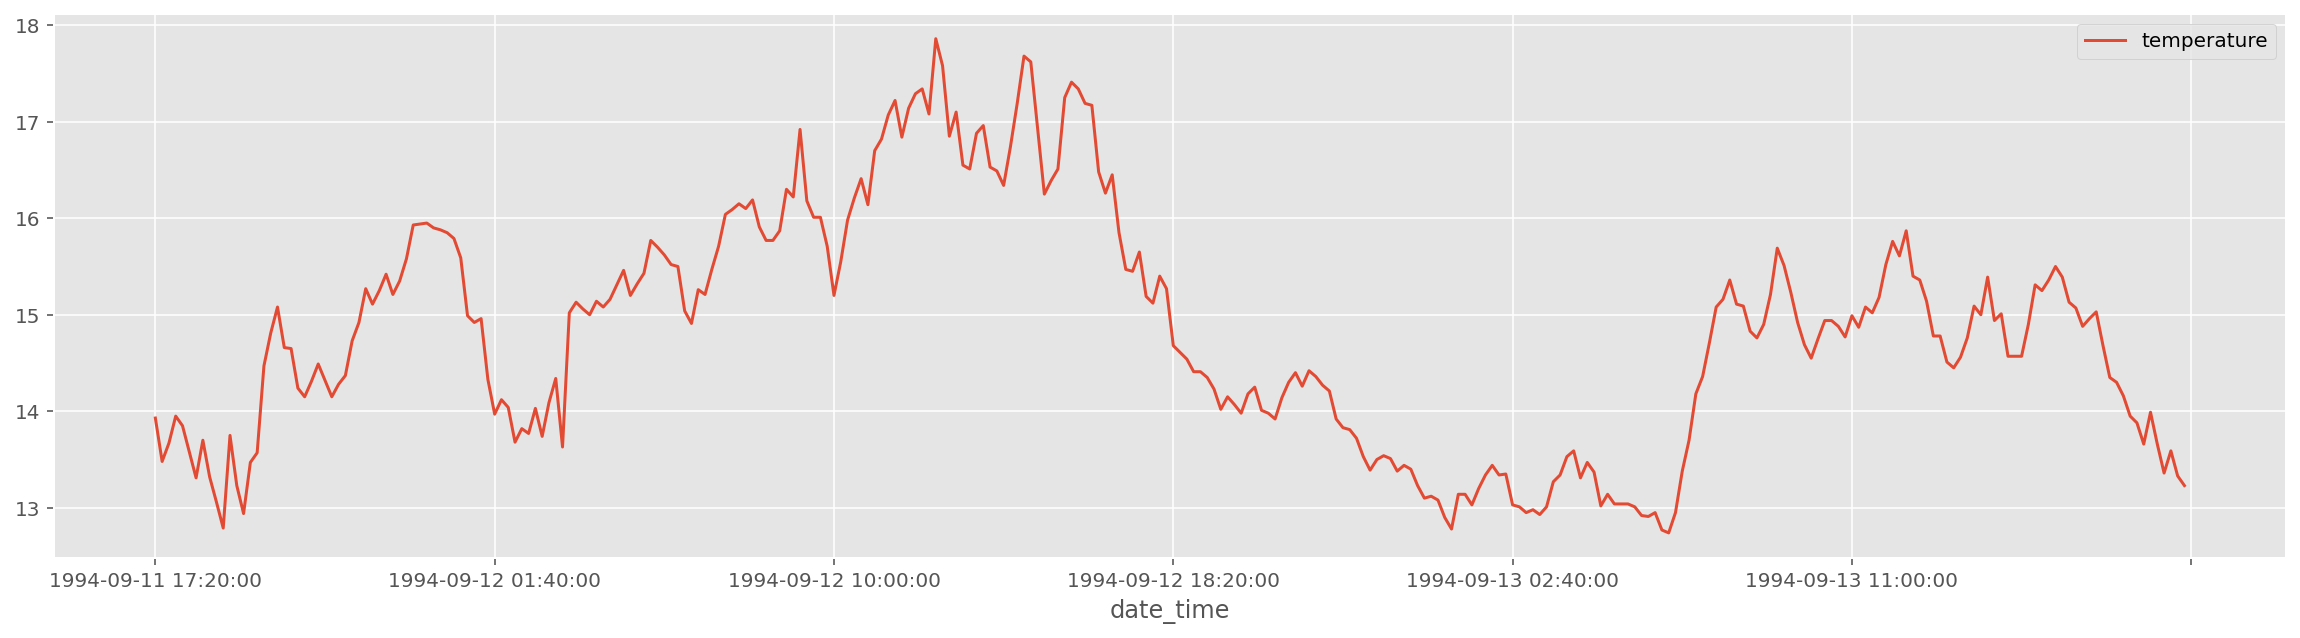

In [74]:
df.iloc[:300].plot('date_time','temperature',figsize=(20,5))
# Looks like the times are HST

## Need to split sustained wind and wind gusts
If '10min' = 1 (up to Nov 2006) then 'wind_speed' is sustained wind and there is no wind gust measurement  
If '10min' = 0 then 'wind_speed' is wind gust and the sustained wind is 2 min average (according to the NOOA)

In [95]:
# use small sample just test 
df_sample = df_2018.iloc[:20].copy()
df_sample.loc[:10,'10min'] = 1
df_sample['date_time'] = pd.to_datetime(df_sample['date_time'])
df_sample.set_index('date_time',inplace=True)

# split the wind into sustained and gusts
df_sample['wind_sust'] = np.where(df_sample['10min']==1,df_sample['wind_speed'],df_sample.wind_speed.rolling('120s').mean())
df_sample['wind_gust'] = np.where(df_sample['10min']==0,df_sample['wind_speed'],np.nan)


df_sample

,temperature,pressure,humidity,wind_speed,wind_direction,visibility,co2,insolation,vertical_wind_speed,precipitation,10min,dewpoint,wind_sust,wind_gust
date_time,,,,,,,,,,,,,,
2018-01-01 00:00:05,12.08,709.12,17.8,5.6,23.0,43682.0,NaN,67.8,-0.1,NaN,1,-42.26,5.600000,NaN
2018-01-01 00:00:15,12.09,709.12,18.1,5.3,26.0,43682.0,NaN,67.8,-0.1,NaN,1,-46.06,5.300000,NaN
2018-01-01 00:00:25,12.07,709.14,18.3,4.8,35.0,46022.0,NaN,67.8,-0.1,NaN,1,-46.98,4.800000,NaN
2018-01-01 00:00:36,12.07,709.16,18.3,3.9,34.0,48408.0,NaN,67.8,-0.1,NaN,1,-38.20,3.900000,NaN
2018-01-01 00:00:46,12.06,709.15,18.8,3.6,24.0,48408.0,NaN,67.8,-0.2,NaN,1,-45.39,3.600000,NaN
2018-01-01 00:00:56,12.07,709.12,19.1,3.7,19.0,48233.0,NaN,67.8,-0.2,NaN,1,-43.03,3.700000,NaN
2018-01-01 00:01:06,12.06,709.15,19.5,3.9,15.0,48233.0,NaN,67.8,-0.1,NaN,1,-33.74,3.900000,NaN
2018-01-01 00:01:16,12.07,709.14,19.4,4.6,21.0,48233.0,NaN,67.8,-0.1,NaN,1,-40.99,4.600000,NaN
2018-01-01 00:01:27,12.06,709.14,19.8,5.1,33.0,48233.0,NaN,67.8,-0.1,NaN,1,-33.48,5.100000,NaN


## Define valid ranges for each column
I noticed some values are not possible (temperatures and dewpoints below -273 deg C). I will use the following for the acceptable ranges.


|               | Min  | Max    | Note                                                                          |
|---------------|------|--------|-------------------------------------------------------------------------------|
| Temperature   | -273 | 40     | below -273 &deg;C not possible, max temperature ever on Maui was less than 40 |
| Humidity      | 0    | 100    |                                                                               |
| Wind Speed    | 0    | 100    |                                                                               |
| Visibility    | 0    | 100000 |                                                                               |
| Precipitation | 0    | 100    |                                                                               |
|  Dew Point    | -273 | T      | Dew point can't be higher than the temperature                                |


In [26]:
# create a small subset of data to check reasonable values against
df_sample = df.iloc[:20].copy()
# change NaNs to numbers for now
df_sample.humidity.mask([True]*len(df_sample),np.random.uniform(50,100,size=len(df_sample)),inplace=True)
df_sample.visibility.mask([True]*len(df_sample),np.random.uniform(30000,50000,size=len(df_sample)),inplace=True)
df_sample.dewpoint.mask([True]*len(df_sample),np.random.uniform(0,40,size=len(df_sample)),inplace=True)

df_sample

,date_time,temperature,humidity,wind_speed,visibility,precipitation,dewpoint
0,1994-09-11 17:20:00,13.93,77.645036,7.35,34271.126042,0.00,18.097282
1,1994-09-11 17:30:00,13.48,95.281115,7.29,36570.915585,0.00,14.709387
2,1994-09-11 17:40:00,13.67,81.953207,7.14,37152.157195,0.00,1.726801
3,1994-09-11 17:50:00,13.95,64.253735,7.31,44093.575422,0.00,5.741308
4,1994-09-11 18:00:00,13.85,88.619415,7.96,48914.325995,0.00,36.627900
5,1994-09-11 18:10:00,13.58,94.359853,8.49,47505.663980,0.00,27.070142
6,1994-09-11 18:20:00,13.31,91.475121,8.52,30164.631014,0.00,32.267309
7,1994-09-11 18:30:00,13.70,88.322315,8.48,43320.239251,0.00,16.907560
8,1994-09-11 18:40:00,13.32,58.747709,7.40,36502.866185,0.00,3.469074
9,1994-09-11 18:50:00,13.06,77.976557,7.60,36390.202163,0.00,1.236184


In [28]:
# for some reason Jupyter wouldn't load this function
def remove_unreasonable_measurements(df,range_limits={
                    'temperature': (-273,40),
                    'humidity': (0,100),
                    'wind_speed': (0,100),
                    'visibility': (0,100000),
                    'precipitation': (0,100),
                    'dewpoint': (-273,40)
                    },inplace=False):
    '''
    Check all values are reasonable and if not change to NaN
    Parameters
    ----------
    df : DataFrame
        DataFrame must have columns: 'date_time','temperature','humidity','wind_speed','visibility','precipitation','dewpoint'
    range_limits : dict
        lower and upper limits for each columns except the date_time
    Return 
    ------
    df_new: DataFrame with NaNs replacing out of range values. - only returned if inplace=False
    '''
    df_new = pd.DataFrame()
    for col in df.drop('date_time',axis=1).columns:
        df_new[col] = df[col].mask((df[col]<range_limits[col][0]) | (df[col]>range_limits[col][1]),inplace=inplace)
    if not inplace:
        return df_new

In [29]:
acceptable_ranges_test = {
                    'temperature': (13,15.02),
                    'humidity': (62.3,84.2),
                    'wind_speed': (7.3,8.5),
                    'visibility': (33000,43000),
                    'precipitation': (0,0),
                    'dewpoint': (9.8,32.2)
                    }
remove_unreasonable_measurements(df_sample,acceptable_ranges_test,inplace=True)
df_sample

,date_time,temperature,humidity,wind_speed,visibility,precipitation,dewpoint
0,1994-09-11 17:20:00,13.93,77.645036,7.35,34271.126042,0.0,18.097282
1,1994-09-11 17:30:00,13.48,NaN,NaN,36570.915585,0.0,14.709387
2,1994-09-11 17:40:00,13.67,81.953207,NaN,37152.157195,0.0,NaN
3,1994-09-11 17:50:00,13.95,64.253735,7.31,NaN,0.0,NaN
4,1994-09-11 18:00:00,13.85,NaN,7.96,NaN,0.0,NaN
5,1994-09-11 18:10:00,13.58,NaN,8.49,NaN,0.0,27.070142
6,1994-09-11 18:20:00,13.31,NaN,NaN,NaN,0.0,NaN
7,1994-09-11 18:30:00,13.70,NaN,8.48,NaN,0.0,16.907560
8,1994-09-11 18:40:00,13.32,NaN,7.40,36502.866185,0.0,NaN
9,1994-09-11 18:50:00,13.06,77.976557,7.60,36390.202163,0.0,NaN


## Determine and set up thresholds
I was able to estimate most thresholds, but cloud cover is not directly tied to a visibility number that the site measures. So I am going to estimate threshold values for it. 

<AxesSubplot:xlabel='date_time'>

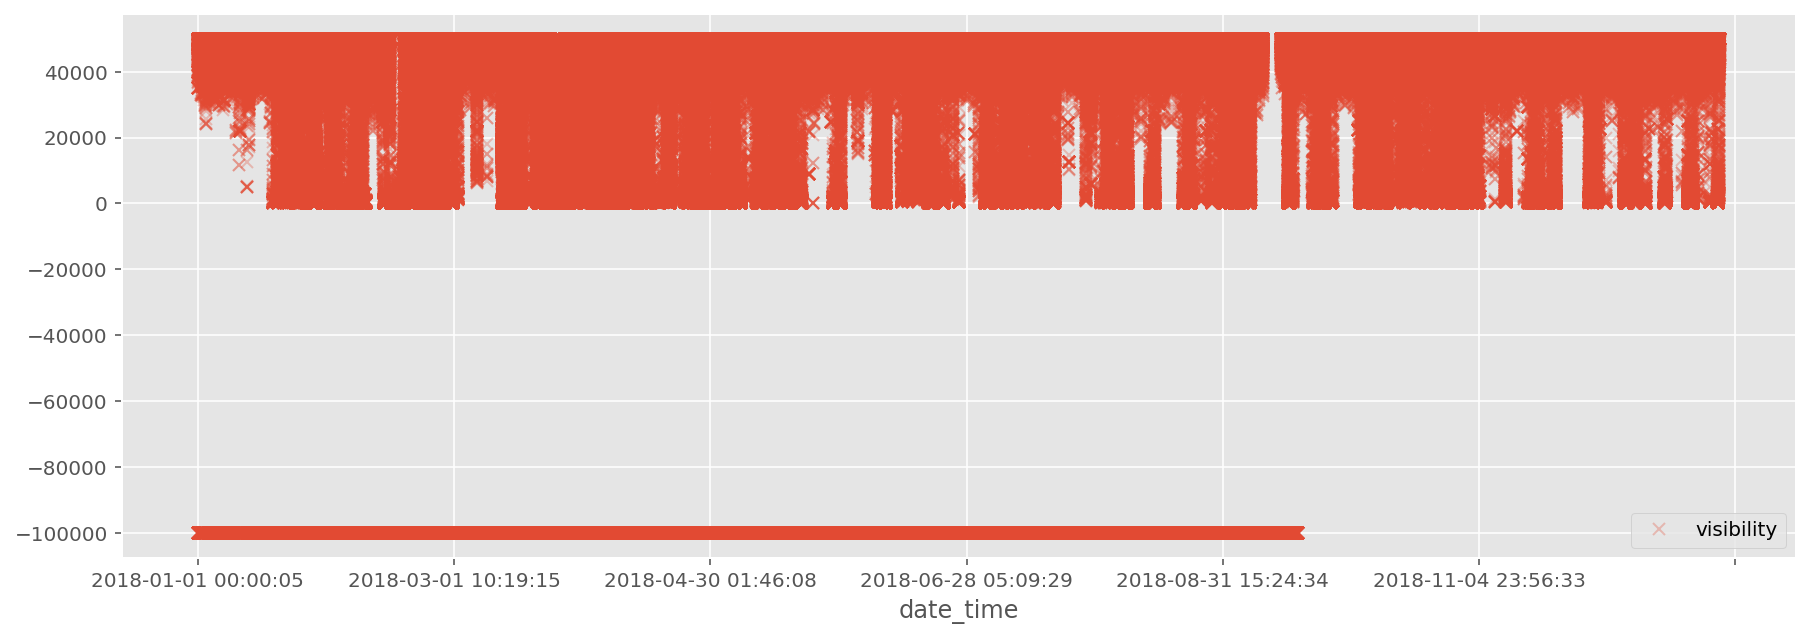

In [49]:
df_2018.plot(x='date_time',y='visibility',figsize=(15,5),alpha=0.3,linestyle='',marker='x')

array([[<AxesSubplot:title={'center':'visibility'}>]], dtype=object)

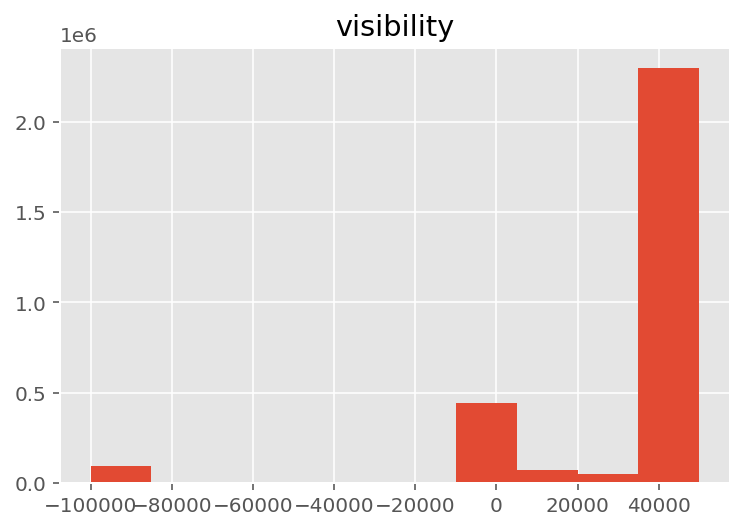

In [43]:
df_2018.hist('visibility')

In [50]:
df_2018.visibility.describe()

count    2.956663e+06
mean     3.600850e+04
std      3.045148e+04
min     -9.999900e+04
25%      4.205800e+04
50%      5.000000e+04
75%      5.000000e+04
max      5.000000e+04
Name: visibility, dtype: float64

In [59]:
sum(df_2018.visibility < 40000) / len(df_2018)

0.2373213892959716

In [60]:
sum(df_2019.visibility < 40000) / len(df_2019)

0.09767412103651238

I am going to use ==50000 as Green and <40000 as red

## Thresolds to use
|      | Units | Green | Yellow | Red |
|:-----|------:|------:|-------:|-----|
|date | YYYY-MM-DD HH\:mm\:ss | N/A | N/A | N/A |
|temperature| &deg;C |  N/A | N/A | N/A  |
|humidity|% | <75 | \[75-85) | >85 |
|wind_speed| m/s | sustained < 10 | | > 12 |
|          |     | gusts < 15 | | > 15 |
|visibility| meters | =50000 | | <40000 |
|precipitation| inches | =0 | | > 0 |
|dewpoint| &deg;C | > 6 | | < 3 |

Need to look at data more to determine map data to threshold for visibility.

In [102]:
thresholds = {
            'humidity': (75,85),
            'wind_sust': (10,12),
            'wind_gust': (15,15),
            'visibility': (50000,40000),
            'precipitation': (0,0),
            'dewpoint_delta': (6,3)
            }

In [97]:
df_sample

,temperature,pressure,humidity,wind_speed,wind_direction,visibility,co2,insolation,vertical_wind_speed,precipitation,10min,dewpoint,wind_sust,wind_gust
date_time,,,,,,,,,,,,,,
2018-01-01 00:00:05,12.08,709.12,17.8,5.6,23.0,43682.0,NaN,67.8,-0.1,NaN,1,-42.26,5.600000,NaN
2018-01-01 00:00:15,12.09,709.12,18.1,5.3,26.0,43682.0,NaN,67.8,-0.1,NaN,1,-46.06,5.300000,NaN
2018-01-01 00:00:25,12.07,709.14,18.3,4.8,35.0,46022.0,NaN,67.8,-0.1,NaN,1,-46.98,4.800000,NaN
2018-01-01 00:00:36,12.07,709.16,18.3,3.9,34.0,48408.0,NaN,67.8,-0.1,NaN,1,-38.20,3.900000,NaN
2018-01-01 00:00:46,12.06,709.15,18.8,3.6,24.0,48408.0,NaN,67.8,-0.2,NaN,1,-45.39,3.600000,NaN
2018-01-01 00:00:56,12.07,709.12,19.1,3.7,19.0,48233.0,NaN,67.8,-0.2,NaN,1,-43.03,3.700000,NaN
2018-01-01 00:01:06,12.06,709.15,19.5,3.9,15.0,48233.0,NaN,67.8,-0.1,NaN,1,-33.74,3.900000,NaN
2018-01-01 00:01:16,12.07,709.14,19.4,4.6,21.0,48233.0,NaN,67.8,-0.1,NaN,1,-40.99,4.600000,NaN
2018-01-01 00:01:27,12.06,709.14,19.8,5.1,33.0,48233.0,NaN,67.8,-0.1,NaN,1,-33.48,5.100000,NaN


In [98]:
df_sample['dewpoint_delta'] = df_sample['temperature'] - df_sample['dewpoint']
df_sample

,temperature,pressure,humidity,wind_speed,wind_direction,visibility,co2,insolation,vertical_wind_speed,precipitation,10min,dewpoint,wind_sust,wind_gust,dewpoint_delta
date_time,,,,,,,,,,,,,,,
2018-01-01 00:00:05,12.08,709.12,17.8,5.6,23.0,43682.0,NaN,67.8,-0.1,NaN,1,-42.26,5.600000,NaN,54.34
2018-01-01 00:00:15,12.09,709.12,18.1,5.3,26.0,43682.0,NaN,67.8,-0.1,NaN,1,-46.06,5.300000,NaN,58.15
2018-01-01 00:00:25,12.07,709.14,18.3,4.8,35.0,46022.0,NaN,67.8,-0.1,NaN,1,-46.98,4.800000,NaN,59.05
2018-01-01 00:00:36,12.07,709.16,18.3,3.9,34.0,48408.0,NaN,67.8,-0.1,NaN,1,-38.20,3.900000,NaN,50.27
2018-01-01 00:00:46,12.06,709.15,18.8,3.6,24.0,48408.0,NaN,67.8,-0.2,NaN,1,-45.39,3.600000,NaN,57.45
2018-01-01 00:00:56,12.07,709.12,19.1,3.7,19.0,48233.0,NaN,67.8,-0.2,NaN,1,-43.03,3.700000,NaN,55.10
2018-01-01 00:01:06,12.06,709.15,19.5,3.9,15.0,48233.0,NaN,67.8,-0.1,NaN,1,-33.74,3.900000,NaN,45.80
2018-01-01 00:01:16,12.07,709.14,19.4,4.6,21.0,48233.0,NaN,67.8,-0.1,NaN,1,-40.99,4.600000,NaN,53.06
2018-01-01 00:01:27,12.06,709.14,19.8,5.1,33.0,48233.0,NaN,67.8,-0.1,NaN,1,-33.48,5.100000,NaN,45.54


In words:

Green if   humidity < min_humidiy_thresh and
           wind_speed < min_wind_thresh and
           visibility >= max_visibility and
           precipitation <= min_prec and
           dewpoint_delta > max_dewpoint_thresh
           
Red if     humidity > max_humidiy_thresh or
           wind_speed > max_wind_thresh or
           visibility < min_visibility or
           precipitation > max_prec or
           dewpoint_delta > max_dewpoint_thresh

Yellow otherwise

Note NaN will always be False in comparisons

In [103]:
df = df_sample.copy()
status_conditions = [
    (df['humidity'] > max(thresholds['humidity'])) | 
    (df['wind_sust'] > max(thresholds['wind_sust'])) | 
    (df['wind_gust'] > max(thresholds['wind_gust'])) | 
    (df['precipitation'] > max(thresholds['precipitation'])) | 
    (df['dewpoint_delta'] < min(thresholds['dewpoint_delta'])) | 
    (df['visibility'] < min(thresholds['visibility']))
    ,
    (df['humidity'] <= min(thresholds['humidity'])) &
    (df['wind_sust'] <= min(thresholds['wind_sust'])) & 
    (df['wind_gust'] <= min(thresholds['wind_gust'])) & 
    (df['precipitation'] <= min(thresholds['precipitation'])) & 
    (df['dewpoint_delta'] >= max(thresholds['dewpoint_delta'])) &
    (df['visibility'] >= max(thresholds['visibility']))
    ]

status_values = ['Red','Green']

In [105]:
df['status'] = np.select(status_conditions,status_values,default='Yellow')
df

,temperature,pressure,humidity,wind_speed,wind_direction,visibility,co2,insolation,vertical_wind_speed,precipitation,10min,dewpoint,wind_sust,wind_gust,dewpoint_delta,status
date_time,,,,,,,,,,,,,,,,
2018-01-01 00:00:05,12.08,709.12,17.8,5.6,23.0,43682.0,NaN,67.8,-0.1,NaN,1,-42.26,5.600000,NaN,54.34,Yellow
2018-01-01 00:00:15,12.09,709.12,18.1,5.3,26.0,43682.0,NaN,67.8,-0.1,NaN,1,-46.06,5.300000,NaN,58.15,Yellow
2018-01-01 00:00:25,12.07,709.14,18.3,4.8,35.0,46022.0,NaN,67.8,-0.1,NaN,1,-46.98,4.800000,NaN,59.05,Yellow
2018-01-01 00:00:36,12.07,709.16,18.3,3.9,34.0,48408.0,NaN,67.8,-0.1,NaN,1,-38.20,3.900000,NaN,50.27,Yellow
2018-01-01 00:00:46,12.06,709.15,18.8,3.6,24.0,48408.0,NaN,67.8,-0.2,NaN,1,-45.39,3.600000,NaN,57.45,Yellow
2018-01-01 00:00:56,12.07,709.12,19.1,3.7,19.0,48233.0,NaN,67.8,-0.2,NaN,1,-43.03,3.700000,NaN,55.10,Yellow
2018-01-01 00:01:06,12.06,709.15,19.5,3.9,15.0,48233.0,NaN,67.8,-0.1,NaN,1,-33.74,3.900000,NaN,45.80,Yellow
2018-01-01 00:01:16,12.07,709.14,19.4,4.6,21.0,48233.0,NaN,67.8,-0.1,NaN,1,-40.99,4.600000,NaN,53.06,Yellow
2018-01-01 00:01:27,12.06,709.14,19.8,5.1,33.0,48233.0,NaN,67.8,-0.1,NaN,1,-33.48,5.100000,NaN,45.54,Yellow


## Need to find a way to deal with NaN values, any conditional results in False. Going to do this in a new notebook. 
This notebook has become messy from jumping between sections. 

<br>

------------------
# This section was just to get a sense of what some of the values were and if they were reasonable

In [80]:
df_2018.dewpoint.describe()

count    2.786126e+06
mean    -1.870640e+03
std      1.367000e+04
min     -9.999900e+04
25%      1.363000e+01
50%      3.200000e+01
75%      4.140000e+01
max      3.019100e+02
Name: dewpoint, dtype: float64

In [81]:
df_2019.dewpoint.describe()

count    1.930107e+06
mean     2.676958e+01
std      1.361005e+01
min      1.000000e-02
25%      1.521000e+01
50%      2.901000e+01
75%      3.833000e+01
max      5.722000e+01
Name: dewpoint, dtype: float64

<AxesSubplot:>

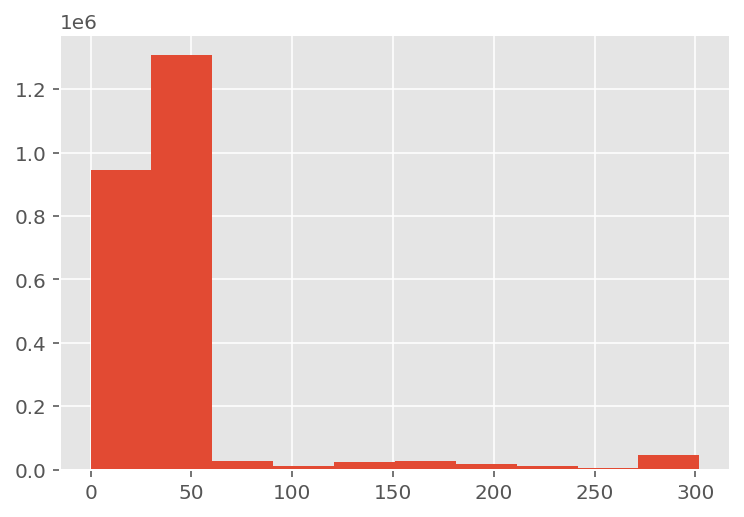

In [84]:
df_2018[df_2018.dewpoint>0].dewpoint.hist()

<AxesSubplot:>

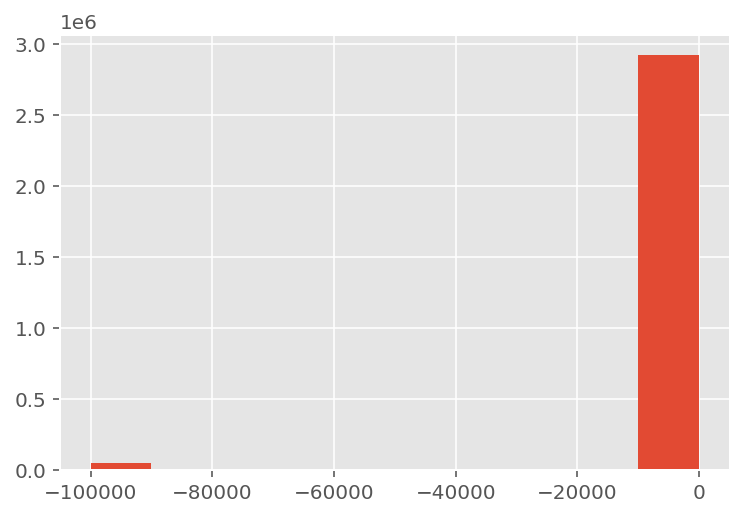

In [86]:
df_2018.temperature.hist()

In [89]:
df_1995.precipitation.describe()

count    47400.000000
mean         0.000819
std          0.006474
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.350000
Name: precipitation, dtype: float64

----------------

<br>